In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score

In [2]:
train_path = 'train.csv'
train_data = pd.read_csv(train_path)
train_data.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [4]:
train_data['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [5]:
train_data.dtypes

id            int64
date         object
country      object
store        object
product      object
num_sold    float64
dtype: object

## Preproccessing

In [7]:
class droping(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.dropna(subset=['num_sold'])
        return X

In [8]:
class droping_cols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(["date", "id"], axis=1)
        return X

In [9]:
class date(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['date'] = pd.to_datetime(X['date'])
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        X['day'] = X['date'].dt.day
        return X

In [10]:
class cols_encode(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        cols = ["country", "product", "store"]
        for col in cols:
            X[col] = LabelEncoder().fit_transform(X[col])
        return X

In [11]:
class sold_scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['num_sold'] = StandardScaler().fit_transform(X[['num_sold']])
        return X


In [12]:
pipeline = Pipeline(
    [
        ("correcting date col", date()),
        ("Encoding cols", cols_encode()),
        ("dropping values", droping()),
        ("dropping columns", droping_cols()),
        ("sold number scaling", sold_scaling())
    ]
)

In [13]:
prepared_train_data = pipeline.fit_transform(train_data)
prepared_train_data.head(10)

,country,store,product,num_sold,year,month,day
1,0,0,1,0.319450,2010,1,1
2,0,0,2,0.222371,2010,1,1
3,0,0,3,-0.477463,2010,1,1
4,0,0,4,-0.378935,2010,1,1
5,0,2,0,-0.655681,2010,1,1
6,0,2,1,1.571326,2010,1,1
7,0,2,2,1.313416,2010,1,1
8,0,2,3,0.078927,2010,1,1
9,0,2,4,0.271635,2010,1,1
10,0,1,0,-0.547011,2010,1,1


## Analyzing the data

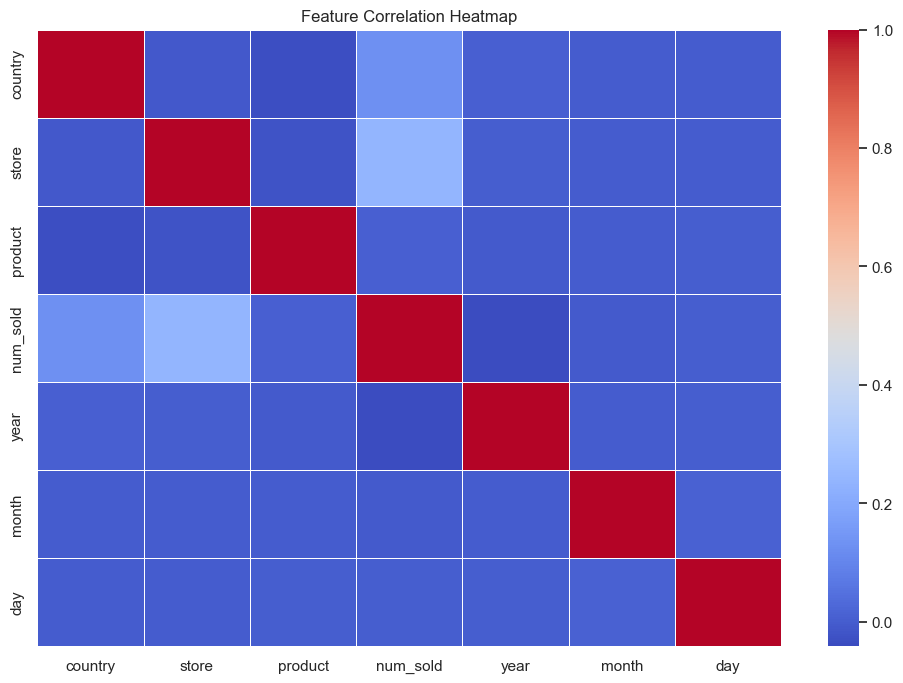

In [15]:
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
corr = prepared_train_data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

C:\Users\Victus\AppData\Local\Temp\ipykernel_30156\1226576403.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


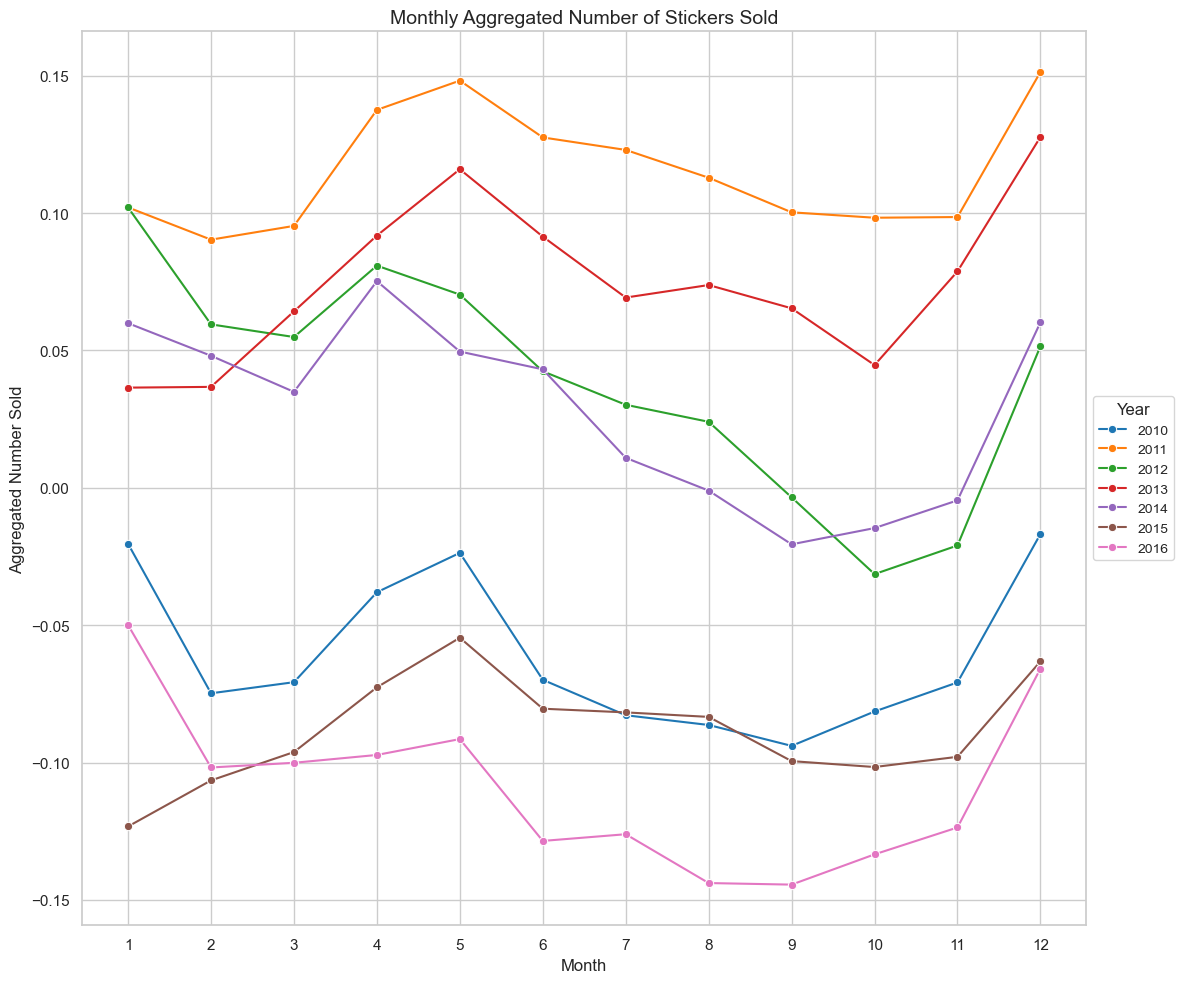

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))

palette = sns.color_palette("tab10", n_colors=len(prepared_train_data['year'].unique()))
sns.lineplot(
    data=prepared_train_data, x='month', y='num_sold', hue='year', marker='o', palette=palette, ax=ax, ci=None
)

ax.set_title('Monthly Aggregated Number of Stickers Sold', fontsize=14)
ax.set_ylabel('Aggregated Number Sold', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.set_xticks(range(1, 13))

ax.legend(title='Year', fontsize=10, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()


## Training Data

In [18]:
X = prepared_train_data.drop("num_sold", axis=1)
y = prepared_train_data["num_sold"]

In [19]:
test_pipeline = Pipeline(
    [
        ("correcting date col", date()),
        ("Encoding cols", cols_encode()),
        ("dropping columns", droping_cols())
    ]
)

test_path = 'test.csv'
test_data = pd.read_csv(test_path)
prepared_test_data = test_pipeline.fit_transform(test_data)
prepared_test_data.head()

,country,store,product,year,month,day
0,0,0,0,2017,1,1
1,0,0,1,2017,1,1
2,0,0,2,2017,1,1
3,0,0,3,2017,1,1
4,0,0,4,2017,1,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
train = lgb.Dataset(X_train, label=y_train)
test = lgb.Dataset(X_test, label=y_test, reference=train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(params, train, valid_sets=[train, test], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 6
[LightGBM] [Info] Start training from score -0.001175
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.226945	valid_1's rmse: 0.231193
[100]	training's rmse: 0.166779	valid_1's rmse: 0.170605
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.166779	valid_1's rmse: 0.170605


In [22]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.1706054296461044

In [26]:
test_preds = model.predict(prepared_test_data)

submission = pd.DataFrame({
    'id': test_data['id'],
    'num_sold': test_preds.astype(bool)
})

submission['num_sold'] = model.predict(prepared_test_data)
submission.to_csv("submission.csv", index=False)
submission.head()

,id,num_sold
0,230130,-0.909261
1,230131,-0.128806
2,230132,-0.269285
3,230133,-0.637818
4,230134,-0.511847
